In [1]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import glob

from core import *
from utils import phantom_builder
from utils import geometry
from utils import utils

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Make Phantom

In [2]:

voxel_size = np.array([0.0005, 0.0005, 0.0005])
surface_mesh = o3d.io.read_triangle_mesh(f"{parent}/assets/breast_phantom/breast_surface.ply")
body_mask = phantom_builder.voxelize(voxel_size[0], mesh=surface_mesh) 

In [3]:
test_phantom = phantom.Phantom(source_path = None,
                               voxel_dims = (voxel_size[0], voxel_size[0], voxel_size[0]),
                               matrix_dims = body_mask.shape,
                               baseline = (1540, 1000),
                               seed = 5678,
                               )

skin = tissue.Tissue(name='skin', c=1624, rho=1109, sigma=1.3, scale=0.00001, label=1)
fat = tissue.Tissue(name='fat', c=1440.2, rho=911, sigma=40, scale=0.0003, label=2)
ligament = tissue.Tissue(name='ligament', c=1750, rho=1142, sigma=30, scale=0.0001, label=3)
gland = tissue.Tissue(name='gland', c=1564, rho=1041, sigma=40, scale=0.0002, label=4)
# tumor = tissue.Tissue(name='tumor', c=1550, rho=1050, sigma=0, scale=0.0001, label=5)
tumor = tissue.Tissue(name='tumor', c=1500, rho=1000, sigma=0, scale=0.001, label=5)
muscle = tissue.Tissue(name='muscle', c=1580, rho=1090, sigma=4, scale=0.001, label=6)

kidney_file_dir = f"{parent}/assets/breast_phantom/"
kidney_tissue_list = [skin, fat, skin, gland, gland, ligament, muscle, tumor]

test_phantom.build_organ_from_mesh(surface_mesh, voxel_size[0], kidney_tissue_list, dir_path = kidney_file_dir)
test_phantom.set_default_tissue('water')

Added skin
Added fat
Added skin
Added gland
Added gland
Added ligament
Added muscle
Added tumor


In [4]:
test = test_phantom.get_complete()

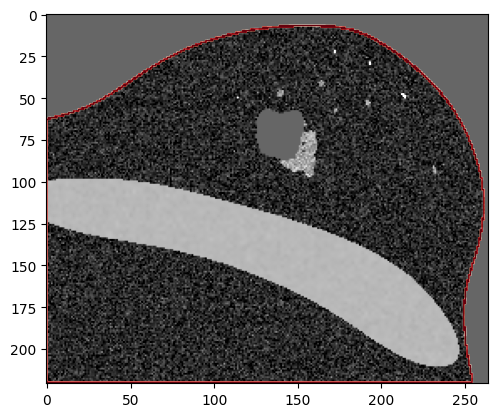

In [5]:
index = 140
plt.imshow(test[0, :, :, index], cmap='gray', vmin=1400, vmax=1650)
plt.imshow(body_mask[:,:, index] * 1000, alpha=0.5*(body_mask[:,:, index]>0)*2, cmap='Reds')

# Set up simulation

In [6]:
num_transducers = 1
transducers = [transducer.Focused(max_frequency = 4e6,
                                  elements = 128, 
                                  width = 20e-3,
                                  height =  20e-3,
                                  sensor_sampling_scheme = 'not_centroid', 
                                  sweep = np.pi/4,
                                  ray_num = 64,
                                  imaging_ndims = 2,
                                  focus_azimuth = 40e-3,
                                  focus_elevation = 60e-3) for i in range(num_transducers)]

# num_transducers = 8
# transducers = [transducer.Focused(max_frequency = 2.5e6,
#                                   elements = 128, 
#                                   width = 20e-3,
#                                   height =  20e-3,
#                                   sensor_sampling_scheme = 'not_centroid', 
#                                   sweep = (np.pi/2,np.pi/2),
#                                   ray_num = (64,64),
#                                   imaging_ndims = 3,
#                                   focus_azimuth = 40e-3,
#                                   focus_elevation = 60e-3) for i in range(num_transducers)]


for t in transducers:
    t.make_sensor_coords(1540) # test_phantom.baseline[0]

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

In [7]:
spread = np.pi * 0.23
position = [-0.07,0,0]
global_transform = geometry.Transform([-np.pi * 0.13,np.pi * -0.05,0],[0.003,0.003,-0.005], intrinsic=False)

transform1 = geometry.Transform([0,0,0], [0,0,0])
transform2 = geometry.Transform([0,0.2,0], [0,0,0])
transform3 = geometry.Transform([0,0,0], [0,0,0])
transform = transform1 * transform2 * transform3
transform.translation = (global_transform * transform1 * transform2).apply_to_point([-0.07,-0.01,0.01], inverse=False)
test_transducer_set.assign_pose(0, global_transform * transform)

# transform1 = geometry.Transform([-spread / 3,0,0], [0,0,0])
# transform2 = geometry.Transform([0,0,0], [0,0,0])
# transform3 = geometry.Transform([0,0,0], [0,0,0])
# transform = transform1 * transform2 * transform3
# transform.translation = (global_transform * transform1 * transform2).apply_to_point(position, inverse=False)
# test_transducer_set.assign_pose(0, global_transform * transform)

# transform1 = geometry.Transform([spread / 3,0,0], [0,0,0])
# transform2 = geometry.Transform([0,0,0], [0,0,0])
# transform3 = geometry.Transform([0,0,0], [0,0,0])
# transform = transform1 * transform2 * transform3
# transform.translation = (global_transform * transform1 * transform2).apply_to_point(position, inverse=False)
# test_transducer_set.assign_pose(1, global_transform * transform)

# transform1 = geometry.Transform([-spread,0,0], [0,0,0])
# transform2 = geometry.Transform([0,0,0], [0,0,0])
# transform3 = geometry.Transform([0,0,0], [0,0,0])
# transform = transform1 * transform2 * transform3
# transform.translation = (global_transform * transform1 * transform2).apply_to_point(position, inverse=False)
# test_transducer_set.assign_pose(2, global_transform * transform)

# transform1 = geometry.Transform([spread,0,0], [0,0,0])
# transform2 = geometry.Transform([0,0,0], [0,0,0])
# transform3 = geometry.Transform([0,0,0], [0,0,0])
# transform = transform1 * transform2 * transform3
# transform.translation = (global_transform * transform1 * transform2).apply_to_point(position, inverse=False)
# test_transducer_set.assign_pose(3, global_transform * transform)

# transform1 = geometry.Transform([-spread / 2,0,0], [0,0,0])
# transform2 = geometry.Transform([0,3 ** 0.5 / 2 * -spread,0], [0,0,0])
# transform3 = geometry.Transform([0,0,0], [0,0,0])
# transform = transform1 * transform2 * transform3
# transform.translation = (global_transform * transform1 * transform2).apply_to_point(position, inverse=False)
# test_transducer_set.assign_pose(4, global_transform * transform)

# transform1 = geometry.Transform([-spread / 2,0,0], [0,0,0])
# transform2 = geometry.Transform([0,3 ** 0.5 / 2 * spread,0], [0,0,0])
# transform3 = geometry.Transform([0,0,0], [0,0,0])
# transform = transform1 * transform2 * transform3
# transform.translation = (global_transform * transform1 * transform2).apply_to_point(position, inverse=False)
# test_transducer_set.assign_pose(5, global_transform * transform)

# transform1 = geometry.Transform([spread / 2,0,0], [0,0,0])
# transform2 = geometry.Transform([0,3 ** 0.5 / 2 * -spread,0], [0,0,0])
# transform3 = geometry.Transform([0,0,0], [0,0,0])
# transform = transform1 * transform2 * transform3
# transform.translation = (global_transform * transform1 * transform2).apply_to_point(position, inverse=False)
# test_transducer_set.assign_pose(6, global_transform * transform)

# transform1 = geometry.Transform([spread / 2,0,0], [0,0,0])
# transform2 = geometry.Transform([0,3 ** 0.5 / 2 * spread,0], [0,0,0])
# transform3 = geometry.Transform([0,0,0], [0,0,0])
# transform = transform1 * transform2 * transform3
# transform.translation = (global_transform * transform1 * transform2).apply_to_point(position, inverse=False)
# test_transducer_set.assign_pose(7, global_transform * transform)

In [8]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')

In [9]:
# np.mean(test_sensor.sensor_coords, axis=0) / voxel_size + np.array(test.shape[1:])/2
np.mean(test_sensor.sensor_coords, axis=0)

array([-0.06201749,  0.02327964,  0.00323013])

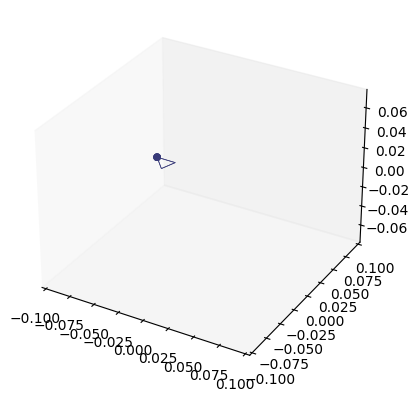

In [10]:
test_transducer_set.plot_transducer_fovs()

In [11]:
for i in range(len(test_transducer_set)):
    p = test_transducer_set[i][1]
    print(p.translation , p.rotation.as_euler('ZYX'))

[-0.06201748  0.02327964  0.00323013] [-0.40044979  0.0555453   0.0622638 ]


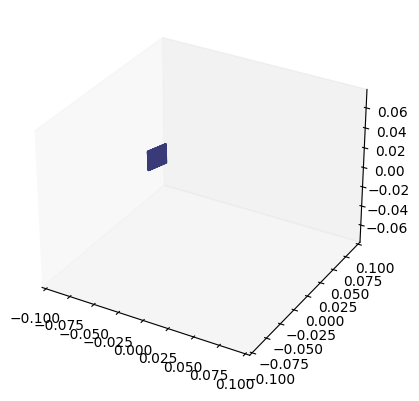

In [12]:
test_transducer_set.plot_transducer_coords()

In [13]:
simprops = simulation.SimProperties(
                grid_size   = (65e-3,20e-3,20e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (8,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [14]:
# test_experiment = experiment.Experiment(
#                  simulation_path = 'breast_tomography',
#                  sim_properties  = simprops,
#                  phantom         = test_phantom,
#                  transducer_set  = test_transducer_set,
#                  sensor          = test_sensor,
#                  nodes           = 1,
#                  results         = None,
#                  indices         = None,
#                  workers         = 3,
#                  additional_keys = []
#                  )

test_experiment = experiment.Experiment(
                 simulation_path = 'breast_2D',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 additional_keys = []
                 )

test_experiment.save()

In [15]:
# utils.save_mrc(test_experiment.get_sensor_mask(pad=50), 'breast_tomography_sensor_mask.mrc')

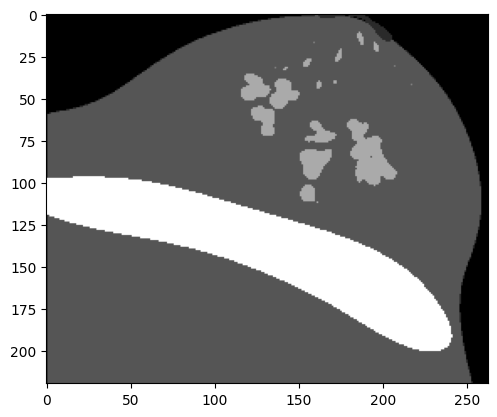

In [16]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), 120])

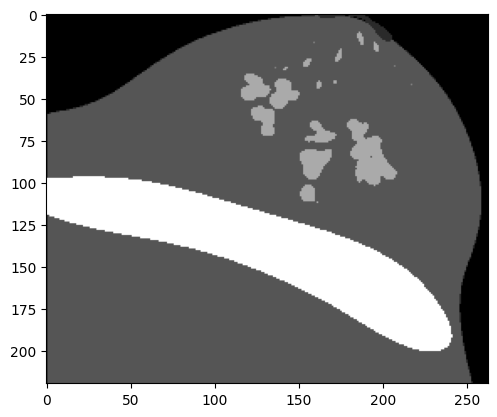

In [17]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), 120])

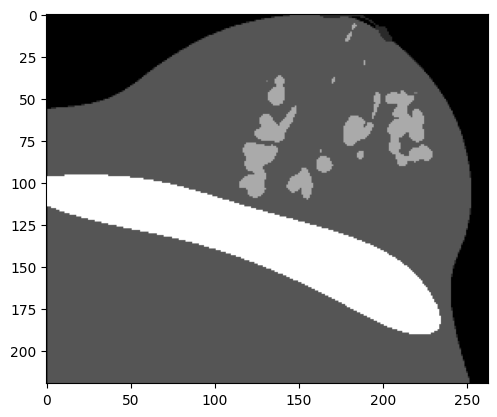

In [18]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), 100])

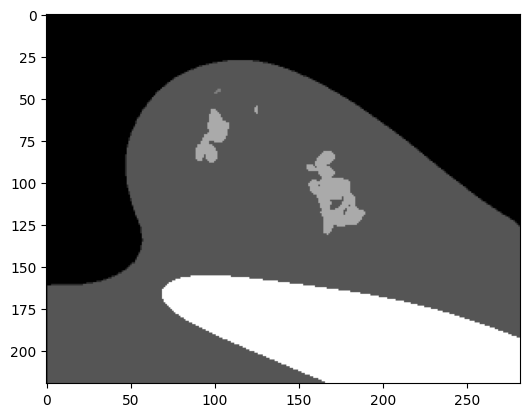

In [19]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), 220, slice(0, -1, 1)])

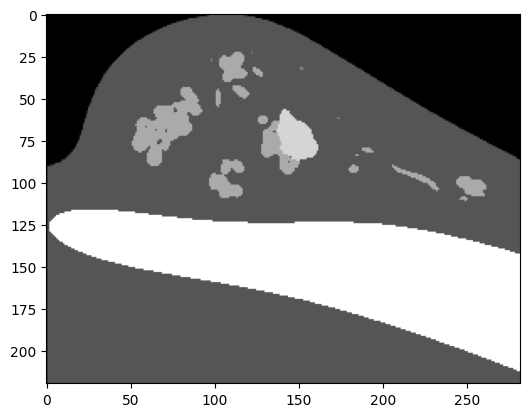

In [20]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), 150, slice(0, -1, 1)])

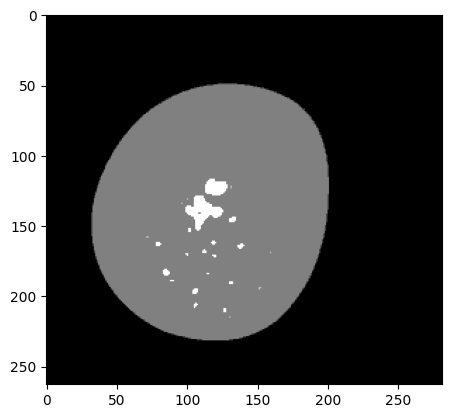

In [21]:
test_experiment.visualize_sensor_mask(index=[40, slice(0, -1, 1), slice(0, -1, 1)])

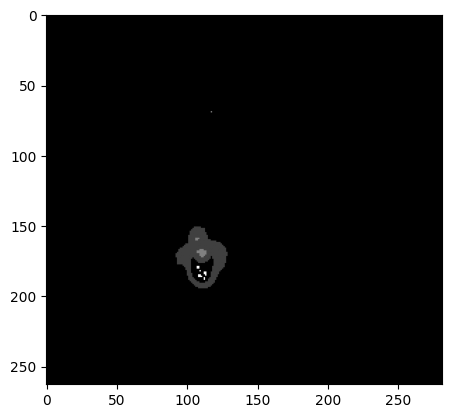

In [22]:
test_experiment.visualize_sensor_mask(index=[0, slice(0, -1, 1), slice(0, -1, 1)])

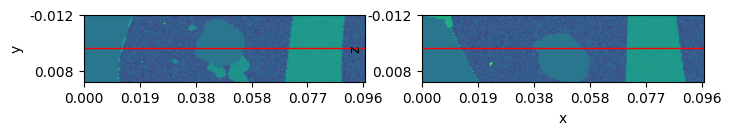

In [24]:
# test_experiment.plot_ray_path(64*32 + 32)
test_experiment.plot_ray_path(32)

# Run Simulation

In [2]:
# test_experiment = experiment.Experiment.load('breast_tomography')
test_experiment = experiment.Experiment.load('breast_2D')
test_experiment.run(dry=True)

Number of simulation results (38) is less than the expected number of simulation results (64), are you sure the simulation finished running?
dry run of simulation


100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


In [3]:
test_experiment.run(repeat=False)

running with 3 workers

preparation for sim   20 completed in 184.50 seconds
preparation for sim   51 completed in 182.46 seconds
preparation for sim   21 completed in 179.63 seconds
preparation for sim   52 completed in 184.38 seconds
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
simulation            20 completed in 775.74 seconds
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
simulation            51 completed in 691.86 seconds
preparation for sim   53 completed in 167.08 seconds
preparation for sim   22 completed in 166.80 seconds
prep worker has been inactive for 5.0 minutes
prep worker has been inactive for 5.0 minutes
simulation            21 completed in 730.33 seconds
prep worker has been inactive for 5.0 m

# Reconstruction

In [4]:
test_experiment.add_results()

In [5]:
test_reconstruction = reconstruction.DAS(experiment=test_experiment)

In [6]:
signals = test_reconstruction.get_signals(dimensions=3, matsize=128, downsample=0.5, workers=24, tgc=10)
# signals = test_reconstruction.get_signals(dimensions=2, matsize=128, downsample=1, workers=24, tgc=10)

100%|██████████| 32768/32768 [05:05<00:00, 107.42it/s]
8it [07:22, 55.25s/it]


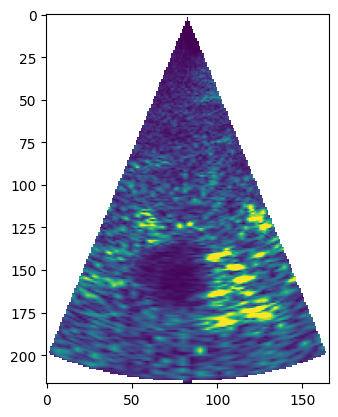

In [6]:
# plt.imshow(signals[0], vmax=200000)

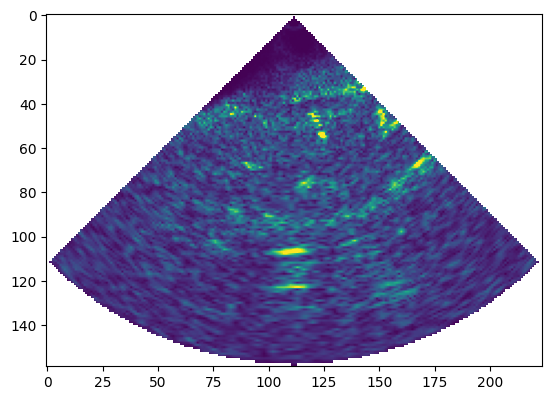

In [ ]:
# plt.imshow(signals[0], vmax=200000)

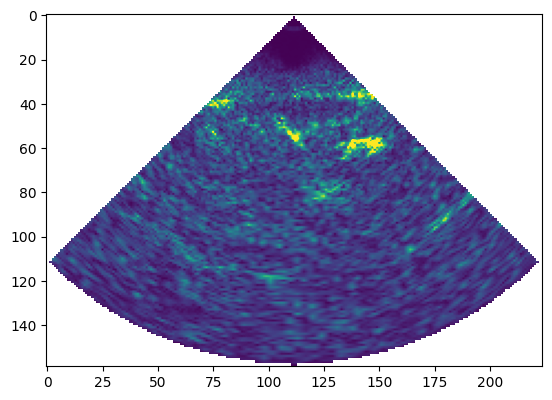

In [ ]:
# plt.imshow(signals[0], vmax=200000)

In [ ]:
# plt.imshow(signals[1], vmax=200000)

In [ ]:
# plt.imshow(signals[2], vmax=200000)

In [ ]:
# plt.imshow(signals[3], vmax=200000)

In [ ]:
# plt.imshow(signals[4], vmax=200000)

In [ ]:
# plt.imshow(signals[5], vmax=200000)

In [ ]:
# plt.imshow(signals[6], vmax=200000)

In [ ]:
# plt.imshow(signals[7], vmax=200000)

In [ ]:
signals[0].shape

(100, 141, 141)

In [7]:
for i,signal in enumerate(signals):
    signal = np.where(np.isnan(signal), 0, signal)
    utils.save_mrc(signal, f'output/breast_tomography_signals_{i}.mrc')

In [6]:
image = test_reconstruction.get_image(dimensions=3, matsize=256, downsample=1, workers=24, tgc=10)
# image = image / np.max(image)
# image = np.where(np.isnan(image), 1, image)
# utils.save_mrc(image, 'output/breast_tomography_image.mrc')

100%|██████████| 32768/32768 [05:12<00:00, 104.77it/s]
8it [3:06:11, 1396.44s/it]


In [7]:
image

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [8]:
newimage = np.where(np.isnan(image), 0, image)
newimage = newimage / np.percentile(newimage, 95)

In [9]:
newimage.shape

(230, 259, 278)

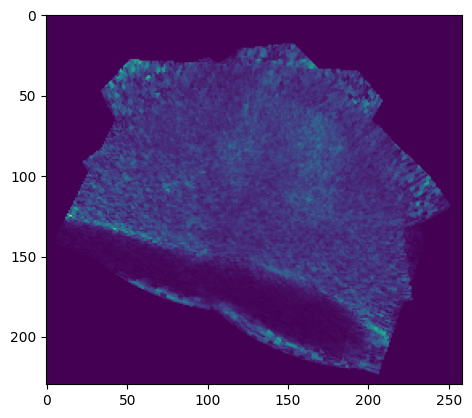

In [10]:
plt.imshow(newimage[:,:,85])

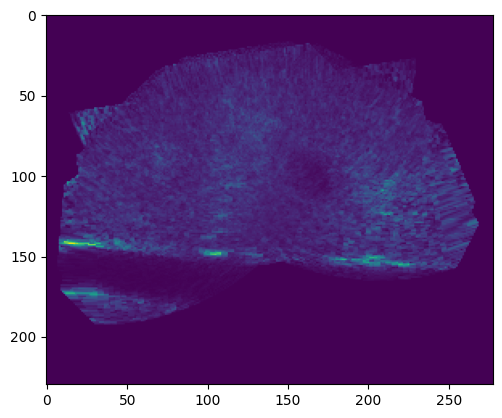

In [11]:
plt.imshow(newimage[:,100,:])

In [12]:
utils.save_mrc(newimage, 'output/breast_tomography_image.mrc')

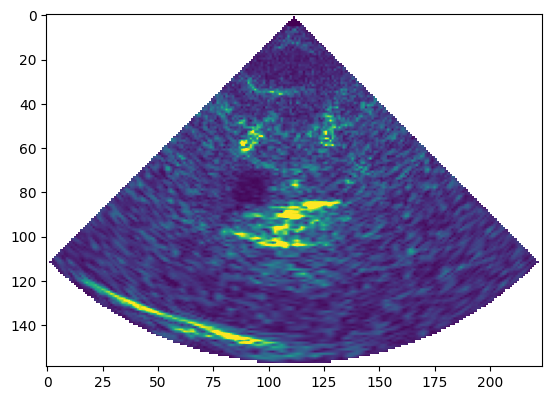

In [ ]:
# plt.imshow(signals[0], vmax=200000)
# 